In [26]:
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
from hydra import compose, initialize
from hydra.utils import instantiate
import numpy as np
import pytorch_lightning as pl
import torch
from torch import Tensor
import torch.nn.functional as F
from einops import rearrange
from torch.utils.data import DataLoader, Dataset
import galsim
from bliss.catalog import TileCatalog, get_is_on_from_n_sources, FullCatalog
from bliss.datasets.background import ConstantBackground
from bliss.datasets.sdss import convert_flux_to_mag
from bliss.models.galsim_decoder import (
    SingleGalsimGalaxyDecoder,
    SingleGalsimGalaxyPrior,
    UniformGalsimGalaxiesPrior,
    load_psf_from_file,
)
from bliss.datasets.galsim_galaxies import GalsimBlends
from case_studies.coadds.signal_noise_ratio import get_snr
from case_studies.coadds.coadd_decoder import (
    CoaddUniformGalsimGalaxiesPrior,
    CoaddSingleGalaxyDecoder,
    CoaddGalsimBlends,
    FullCatalogDecoder,
)
from case_studies.coadds.align_single_exposures import align_single_exposures

In [27]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
with initialize(config_path="../coadds/config"):
    cfg = compose("config", overrides=[])

In [12]:
prior = instantiate(cfg.datasets.sdss_galaxies_coadd.prior)
decoder = instantiate(cfg.datasets.sdss_galaxies_coadd.decoder)
background = instantiate(cfg.datasets.sdss_galaxies_coadd.background)

In [13]:
# check prior to get galaxy parameters
max_n_sources = 1
max_shift = 0.5
num_dithers = 4
sampled_cuggp = CoaddUniformGalsimGalaxiesPrior(
    prior, max_n_sources, max_shift, num_dithers
).sample(num_dithers)

In [14]:
pixel_scale = 0.393
n_sources = sampled_cuggp["n_sources"]
galaxy_params = sampled_cuggp["galaxy_params"]
locs = sampled_cuggp["locs"]
galaxy_bools = sampled_cuggp["galaxy_bools"]
star_bools = sampled_cuggp["star_bools"]
dithers = sampled_cuggp["dithers"]
offset = None

In [15]:
# check decoder to render galaxies
csgd = CoaddSingleGalaxyDecoder(
    decoder, decoder.n_bands, decoder.pixel_scale, "./data/sdss/psField-000094-1-0012-PSF-image.npy"
)
csgdgalaxy = csgd.render_galaxy(
    galaxy_params=galaxy_params[0],
    slen=decoder.slen,
    psf=decoder.psf,
    offset=offset,
    dithers=dithers,
)

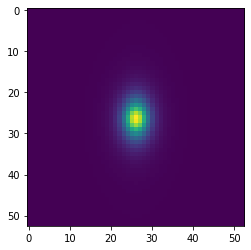

In [23]:
plt.imshow(csgdgalaxy[0].reshape(csgdgalaxy[0].shape[1], csgdgalaxy[0].shape[2]).numpy())

In [81]:
# check FullCatalogDecoder
prior = instantiate(cfg.datasets.galsim_blended_galaxies_coadd.prior)
decoder = instantiate(cfg.datasets.galsim_blended_galaxies_coadd.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies_coadd.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 1000
n_batches = 1
full_catalog = CoaddGalsimBlends(
    prior=prior,
    decoder=decoder,
    background=background,
    tile_slen=tile_slen,
    max_sources_per_tile=max_tile_n_sources,
    num_workers=num_workers,
    batch_size=batch_size,
    n_batches=n_batches,
)._sample_full_catalog()

In [82]:
slen = 40
bp = 24
fcdecoder = FullCatalogDecoder(decoder, slen, bp, dithers)

In [83]:
image, noiseless_centered, noiseless_uncentered, image0 = decoder.render_catalog(
    full_catalog, decoder.single_decoder.psf, dithers
)

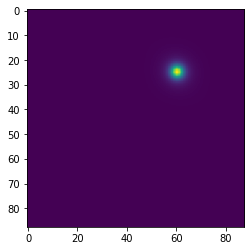

In [84]:
plt.imshow(image0[0].reshape(image0[0].shape[1], image0[0].shape[2]).numpy())

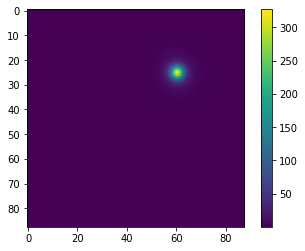

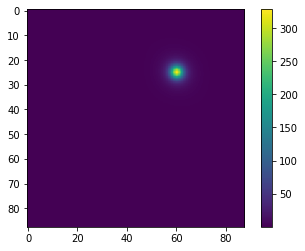

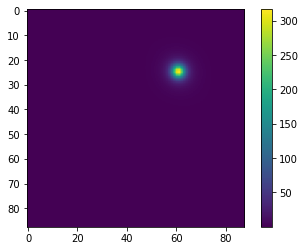

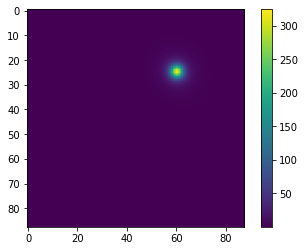

In [85]:
for i in range(image.shape[0]):
    plt.figure()
    plt.imshow(image[i].reshape(image[i].shape[1], image[i].shape[2]).numpy())
    plt.colorbar()

In [88]:
noiseless, noiseless_centered, noiseless_uncentered, background, snr_images, coadded_image, = CoaddGalsimBlends(
    prior=prior,
    decoder=decoder,
    background=background,
    tile_slen=tile_slen,
    max_sources_per_tile=max_tile_n_sources,
    num_workers=num_workers,
    batch_size=batch_size,
    n_batches=n_batches,
)._get_images(full_catalog, dithers)

In [89]:
coadded_image.shape

torch.Size([4, 86, 86])

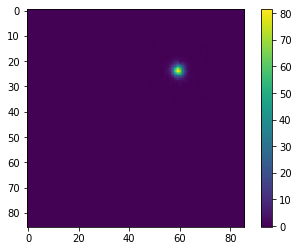

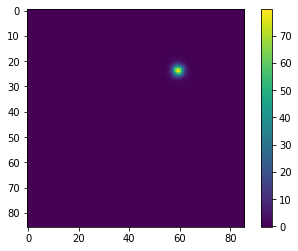

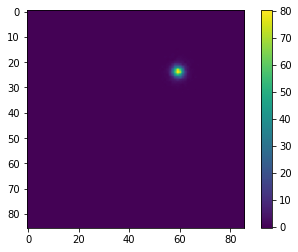

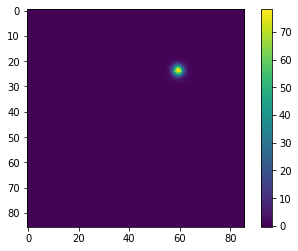

In [91]:
for i in range(coadded_image.shape[0]):
    plt.figure()
    plt.imshow(coadded_image[i].reshape(coadded_image.shape[1], coadded_image.shape[2]).numpy())
    plt.colorbar()